# 2. (Deep) CNNs for Image Colorization

In [54]:
from keras.layers import Dropout, MaxPooling2D, Conv2D, Dense
from keras.datasets import cifar10
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from skimage.color import rgb2grey
from keras.models import Sequential
import io
import numpy as np
import pandas as pd
import keras
%matplotlib inline

### (a) This assignment uses a convolutional neural network for image colorization which
### turns a grayscale image to a colored image.5 By converting an image to grayscale,
### we loose color information, so converting a grayscale image back to a colored
### version is not an easy job. We will use the CIFAR-10 dataset. Downolad the
### dataset from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz.

In [55]:
(X_training, y_training), (X_testing, y_testing) = cifar10.load_data()

In [56]:
X = np.vstack((X_training,X_testing))
y = np.vstack((y_training,y_testing))
we

### (b) From the train and test dataset, extract the class birds. We will focus on this
### class, which has 6000 members.

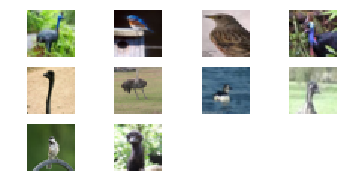

In [57]:
indexes = [m for m,n in enumerate(y) if n == 2]
X = X[indexes]
y = y[indexes]
for i in range(0,10):
    axis = plt.subplot(4,4,i+1)
    axis.imshow(X[i])
    plt.axis('off')
plt.show()

In [58]:
X.shape, y.shape

((6000, 32, 32, 3), (6000,))

### (c) Those 6000 images have 6000 × 32 × 32 pixels. Choose at least 10% of the pixels
### randomly. It is strongly recommended that you choose a large number or all of
### the pixels. You will have between P = 614400 and P = 6144000 pixels. Each
### pixel is an RGB vector with three elements.

In [59]:
X = X.reshape((6144000,3))
X.shape

(6144000, 3)

### (d) Run k-means clustering on the P vectors using k = 4. The centers of the clusters
### will be your main colors. Convert the colored images to k-color images by converting
### each pixel’s value to the closest main color in terms of Euclidean distance.
### These are the outputs of your network, whose each pixel falls in one of those k
### classes

In [60]:
kmeans = KMeans(n_clusters=4,random_state=0)
kmeans = kmeans.fit(X)
kmeans.cluster_centers_

array([[108.97036568, 108.60691289,  82.66458238],
       [206.53651167, 211.77549799, 211.39857871],
       [156.18468173, 155.51640472, 135.57285659],
       [ 49.02965771,  50.01208333,  38.57034319]])

In [66]:
X_modified = X
for i in range(len(X)):
    X_modified[i] = kmeans.cluster_centers_[kmeans.labels_[i]]

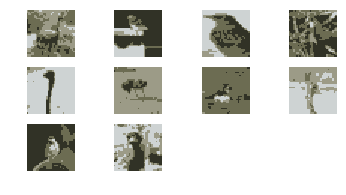

In [67]:
X_vizual = X_modified.reshape((6000,32,32,3))
for i in range(0,10):
    axis = plt.subplot(4,4,i+1)
    axis.imshow(X_vizual[i])
    plt.axis('off')
plt.show()

In [68]:
y_resha = keras.utils.to_categorical(kmeans.labels_).reshape((6000,32,32,4))
X = X.reshape((6000,32,32,3))
X_resha = []
for i in range(len(X)):
    X_resha.append(rgb2grey(X[i]).tolist())
X_resha = np.array(X_resha)

### (e) Use any tool (e.g., openCV or scikit-learn) to obtain grayscale 32 × 32 × 1 images
### from the original 32 × 32 × 3 images. The grayscale images are inputs of your
### network.

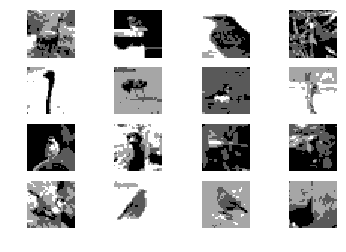

In [71]:
for i in range(0,16):
    axis = plt.subplot(4,4,i+1)
    axis.imshow(X_resha[i],cmap='gray')
    plt.axis('off')
plt.show()

In [73]:
X_resha = X_resha.reshape((6000,32,32,1))
X_training = X_resha[0:5984]
y_training = X_resha[0:5984]
X_testing = X_resha[-16:]
y_testing = X_resha[-16:]
X_training = np.vstack((X_training,X_testing))
y_training = np.vstack((y_training,y_testing))

### (f) Set up a deep convolutional neural network with two convolution layers (or more)
### and two (or more) MLP layers. Use 5 × 5 filters and a softmax output layer.
### Determine the number of filters, strides, and whether or not to use padding yourself.
### Use a minimum of one max pooling layer. Use a classification scheme, which
### means your output must determine one of the k = 4 color classes for each pixel in
### your grayscale image. Your input is a grayscale version of an image (32 × 32 × 1)
### and the output is 32 × 32 × 4. The output assigns one of the k = 4 colors to
### each of the 32 × 32 pixels; therefore, each of the pixels is classified into one of the
### classes [1 0 0 0], [0 1 0 0], [0 0 1 0], [0 0 0 1]. After each pixel is classified into one
### of the main colors, the RGB code of that color can be assigned to the pixel. For
### example, if the third main color 7
### is [255 255 255] and pixel (32,32) of an image
### has the one-hot encoded class [0 0 1 0], i.e it was classified as the third color, the
### (32,32) place in the output can be associated with [255 255 255]. The size of the
### output of the convolutional part, c1 × c2 depends on the size of the convolutional
### layers you choose and is a feature map, which is a matrix. That matrix must be
### flattened or reshaped, i.e. must be turned into a vector of size c1c2 ×1, before it is
### fed to the MLP part. Choose the number of neurons in the first layer of the MLP
### (and any other hidden layers, if you are willing to have more than one hidden
### layer) yourself, but the last layer must have 32 × 32 × 4 = 4096 neurons, each of
### which represents a pixel being in one of the k = 4 classes. Add a softmax layer8
### which will choose the highest value out of its k = 4 inputs for each of the 1024
### pixels; therefore, the output of the MLP has to be reshaped into a 32 × 32 × 4
### matrix, and to get the colored image, the RGB vector of each of the k = 4 classes
### has to be converted to the RGB vector, so an output image will be 32 × 32 × 3.
### Train at least for 5 epochs (30 epochs is strongly recommended). Plot training,
### (validation), and test errors in each epoch. Report the train and test errors and
### visually compare the artificially colored versions of the first 10 images in the test
### set with the original images.

In [75]:
c = Sequential()
c.add(Conv2D(64, kernel_size = (5,5), strides=(1, 1), padding='same', input_shape = (32,32,1)))
c.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
c.add(Conv2D(64, kernel_size = (5,5), strides=(1, 1), padding='same'))
c.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
c.add(Dense(32, activation='softmax'))
c.add(Dense(4, activation='softmax'))
c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1664      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dense_3 (Dense)              (None, 32, 32, 32)        2080      
_________________________________________________________________
dense_4 (Dense)              (None, 32, 32, 4)         132       
Total params: 106,340
Trainable params: 106,340
Non-trainable params: 0
_________________________________________________________________


In [76]:
c.compile(loss='categorical_crossentropy', optimizer='sgd', metrics = ['accuracy'])

Train on 5400 samples, validate on 600 samples
Epoch 1/30
5400/5400 [==============================] - 125s 23ms/step - loss: 1.3724 - acc: 0.3385 - val_loss: 1.3636 - val_acc: 0.3317
Epoch 2/30
5400/5400 [==============================] - 120s 22ms/step - loss: 1.3548 - acc: 0.3385 - val_loss: 1.3538 - val_acc: 0.3317
Epoch 3/30
5400/5400 [==============================] - 113s 21ms/step - loss: 1.3466 - acc: 0.3385 - val_loss: 1.3493 - val_acc: 0.3317
Epoch 4/30
5400/5400 [==============================] - 101s 19ms/step - loss: 1.3424 - acc: 0.3385 - val_loss: 1.3468 - val_acc: 0.3317
Epoch 5/30
5400/5400 [==============================] - 104s 19ms/step - loss: 1.3396 - acc: 0.3385 - val_loss: 1.3449 - val_acc: 0.3317
Epoch 6/30
5400/5400 [==============================] - 106s 20ms/step - loss: 1.3373 - acc: 0.3385 - val_loss: 1.3429 - val_acc: 0.3317
Epoch 7/30
5400/5400 [==============================] - 102s 19ms/step - loss: 1.3349 - acc: 0.3385 - val_loss: 1.3404 - val_acc: 0

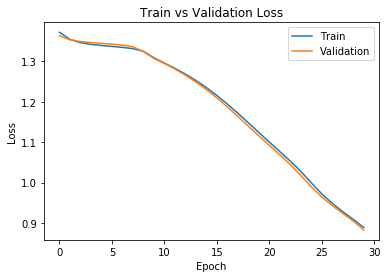

In [28]:
history = c.fit(X_training, y_training, epochs=30, validation_split=0.1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [40]:
prediction = c.predict(X_testing)

In [41]:
prediction = prediction.reshape((16384,4))

In [42]:
pred = prediction[:,0:3]

In [43]:
for i in range(len(prediction)):
    pred[i] = kmeans.cluster_centers_[np.argmax(prediction[i])].tolist()

In [44]:
pred = pred.reshape((600,32,32,3))

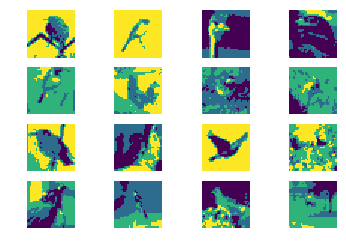

In [45]:
for i in range(0,16):
    axis = plt.subplot(4,4,i+1)
    arr = X_testing.reshape(16,32,32)[i]
    axis.imshow(arr)
    plt.axis('off')
plt.show()